# Text Classification: Supervision

In the [previous tutorial](https://earlyprint.org/jupyterbook/unsupervised.html), we attempted to use an unsupervised method, K-means clustering, to create groups or clusters of our 1666 texts into genres. But we concluded that clustering might not be the ideal method for our data.

Thankfully, unsupervised methods aren't the only way we can classify texts. We can use *supervision*, or *supervised classification*, to sort our texts into groups based on our knowledge of existing categories. Essentially, we give the classifier some texts with categories already labeled and ask it to guess at categories for the unlabeled data. The term "machine learning" is most often used to describe to this process, because the classifier "learns" the categories based on the labeled samples.

The supervised classifier we'll use is one of the simplest and oldest: [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), or logit. It's mathematically related to the common statistical technique of [linear regression](https://en.wikipedia.org/wiki/Linear_regression). Where linear regression can predict *values*, logistic regression can predict *categories* (in other words: classify). While traditional logistic regression is a binary classifier, predicting whether data belongs in one of two categories, we can use multinomial logit to predict things in more than two categories.

We begin by importing the necessary libraries and functions. These are similar to our imports for unsupervised clustering, but with different libraries and models from `sklearn`.

In [2]:
# General Libraries Needed
import glob, csv
import pandas as pd
from collections import defaultdict, Counter
from lxml import etree

# Functions for Supervised Classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Reading a Text Corpus

This first step is identical to what we did in the last tutorial, loading our corpus of 1666 texts and getting Tf-Idf values for each word. Here's an important note from the last lesson:

>In previous tutorials, we extracted lists of words from the XML files and converted them to Tf-Idf values using `TfidfTransformer`. That would still work in this case, but in order to place some additional limits on Tf-Idf, we'll convert the text from our XML back into strings. We can put those strings into `TfIdfVectorizer`, which will give us access to those additional limits (see below). The next code block extracts all the lemmas from our texts and converts them into strings.

In [3]:
# Use the glob library to create a list of file names
filenames = glob.glob("1666_texts_full/*.xml")
# Parse those filenames to create a list of file keys (ID numbers)
# You'll use these later on.

filekeys = [f.split('/')[-1].split('.')[0] for f in filenames]
# Create an empty lists to put all our texts into
all_tokenized = []
all_strings = []

nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}
parser = etree.XMLParser(collect_ids=False) # Create a parse object that skips XML IDs (in this case they just slow things down)

# Then you can loop through the files
for f in filenames:
    tree = etree.parse(f, parser) # Parse each file into an XML tree
    xml = tree.getroot() # Get the XML from that tree
    # Now we can use lxml to find all the w tags
    # In this next line you'll do several things at once to create a list of words for each text
    # 1. Loop through each word: for word in word_tags
    # 2. Make sure the tag has a word at all: if word.text != None
    # 3. Get the lemmatized form of the word: word.get('reg', word.text)
    # 4. Make sure all the words are in lowercase: .lower()
    words = [word.get('lemma', word.text).lower() for word in xml.iter("{*}w") if word.text != None]
    full_string = ' '.join(words)
    # Then we add these results to a master list
    all_strings.append(full_string)

And now we can calculate Tf-Idf, just as we did last time:

>Now that we have strings for each text, we can "vectorize" them into Tf-Idf values. Scikit-learn provides [many options and parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) for its `TfidfVectorizer` that aren't available in the `TfidfTransformer` we used in previous tutorials. Specifically, we want to use the `min_df` parameter to set the minimum document frequency to 2: this will filter out all words that appear in fewer than two texts. This creates a smaller list of features and will allow our models to run more quickly and more accurately.

In [4]:
# First we need to create an "instance" of the vectorizer, with the proper settings.
# Normalization is set to 'l2' by default
tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)
# I am choosing to turn on sublinear term frequency scaling, which takes the log of
# term frequencies and can help to de-emphasize function words like pronouns and articles. 
# You might make a different choice depending on your corpus.

# Once we've created the instance, we can "transform" our counts
results = tfidf.fit_transform(all_strings)

# Make results readable using Pandas
readable_results = pd.DataFrame(results.toarray(), index=filekeys, columns=tfidf.get_feature_names()) # Convert information back to a DataFrame
readable_results

,00,01,02,03,04,05,06,08,09,10,...,zodiac,zoilus,zona,zonara,zone,zophar,zoroaster,zosimus,zouch,zwinglius
B02845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A32444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A51130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017101,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A89320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059049,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011049,...,0.028335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A57156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033300,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A57634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A65985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B03763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041815,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have a dataset that tells us about the features of every text in our corpus!

## Targets

Before we can begin using a supervised method, we need to add one more piece of data to our matrix. In addition to *samples* and *features*, matrices can also have *targets*, i.e. category labels that particular samples fall into. These targets can be used to *train* a classifier by telling it what to expect.

In this case, we need targets that label the genre of a text. Rather than assigning genre labels ourselves, we can pull targets from the [metadata](https://earlyprint.org/jupyterbook/metadata.html). As I mentioned in the last section, the logit method we'll use can handle multiple categories at once, so let's choose a couple different generic categories. We'll use two of the most common subject labels in *EarlyPrint*: history and poetry. We'll also have a third "neither" category for texts that don't belong to either group.

*n.b. This is a flawed example! In a real research situation you may want your categories to be more precise, and you may want a more apples-to-apples comparison than history and poetry, which are very different. And "history" itself is a very fuzzy category that may include different kinds of texts! You may also want to avoid a catch-all "neither" category. However, for the purposes of **learning the method**, it helps to have categories that are very different.*

In [25]:
targets = []

for filekey in filekeys:
    filename = f'../../epmetadata/header/{filekey}_header.xml' # Get TCP ID from filename
    metadata = etree.parse(filename, parser) # Create lxml tree for metadata
    # Find all the keywords in each text
    keywords = [k.text.lower().strip('.') for k in metadata.findall(".//tei:item", namespaces=nsmap)]
    # Search in those keywords for the word "sermon" or words pertaining to poetry
    poetry_terms = ['poetry', 'broadside poems', 'poems']
    if any(k in poetry_terms for k in keywords):
        targets.append('poetry')
    elif any('history' in k for k in keywords):
        targets.append('history')
    else:
        targets.append('neither')

print(targets)
print(Counter(targets))

['poetry', 'history', 'poetry', 'neither', 'history', 'neither', 'history', 'neither', 'neither', 'neither', 'history', 'poetry', 'history', 'neither', 'poetry', 'neither', 'history', 'neither', 'neither', 'poetry', 'history', 'history', 'neither', 'neither', 'poetry', 'neither', 'neither', 'history', 'neither', 'neither', 'neither', 'poetry', 'neither', 'history', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'history', 'neither', 'history', 'history', 'poetry', 'history', 'history', 'poetry', 'neither', 'neither', 'history', 'poetry', 'neither', 'neither', 'neither', 'poetry', 'neither', 'neither', 'neither', 'history', 'poetry', 'neither', 'neither', 'poetry', 'poetry', 'neither', 'neither', 'neither', 'history', 'neither', 'poetry', 'poetry', 'history', 'history', 'neither', 'neither', 'history', 'neither', 'neither', 'neither', 'history', 'neither', 'history', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'neither', 'po

We can see that `targets` is simply a list of labels for each text in our corpus. Importantly, the list is in the same order as the texts in our Tf-Idf matrix.

If we count the categories up, we can see that 49 of our texts contain poetry, 58 of our texts are labeled with history, and 162 have neither label. (When texts were labeled both "poetry" and "history," I kept the label "poetry." The actual counts of poetry and historical texts in this corpus are probably larger, but this is what we can find using the existing subject headings.)

## Supervised Classification

Now that we have target labels, we can use them to train a *supervised classifier* to determine genre categories. Unlike with K-means clustering, where we simply create a model and plug in the entire dataset, we need to split our data into a *training set*, which we use to help our model learn, and a *test set*, which we use to see how the model did. In our case, we'll split our data approximately in half, using just over half of the plays for training and reserving the rest for testing. 

We need to split both the feature set (denoted by a capital X) and the target labels (denoted by a lowercase y). Luckily, scikit-learn does all of this for us with its `train_test_split()` function.

Once the data is split, we can choose a model to train. In this case, the method I've chosen is logistic regression (logit). As I mentioned before, logit is quite an old method for classification, and it is useful in part because it is easy to explain and provides results that (as we shall see) are easier to interpret than newer methods like neural networks. Logistic regression uses a logistic function to draw an s-shaped [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function) that takes any value and converts it to a value between 0 and 1. The closer the value is to 0 or 1, the more closely it belongs in one category or another. Because of this 0-or-1, one-or-the-other feature, logit was originally only a *binary* classifier: it could only tell if something was in one of just two categories. However, we can use multiclass or multinomial logistic regression, and the model will predict all three of our classes at once.

In the code below, we'll split the data automatically, create a logistic regression model, and "fit" that model using the training data. Then, we'll run the model to *predict* categories for the texts in the test set. In the end, we can get accuracy scores, as well as a list of the texts in the test set with their real and predicted genres.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(readable_results, targets, test_size=0.45, random_state=42)
lr = LogisticRegression(random_state=0, solver='lbfgs', penalty='none')
clf = lr.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# evaluate accuracy
print("Accuracy score:", accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
print("Results of this run:\n")
print("Play Title | Actual Genre | Predicted Genre")
for title, real, predicted in zip(X_test.index, y_test, y_pred):
    print(f"{title} | {real} | {predicted}")

Accuracy score: 0.7540983606557377

Results of this run:

Play Title | Actual Genre | Predicted Genre
A41058 | neither | neither
A23770 | neither | neither
A71231 | neither | neither
B05875 | poetry | poetry
A37237 | history | neither
A47095 | neither | neither
A50075 | history | neither
B03489 | poetry | poetry
B04154 | poetry | poetry
A23912 | neither | neither
B06375 | poetry | poetry
B03763 | neither | neither
A67335 | poetry | poetry
A27397 | neither | neither
A41072 | neither | neither
A47379 | neither | neither
A41527 | neither | neither
A57634 | neither | neither
A48909 | neither | neither
A64918 | history | history
A60948 | neither | neither
A44478 | neither | poetry
A32751 | history | neither
A62436 | neither | neither
A67572 | neither | neither
A61956 | neither | neither
A86466 | neither | history
B04338 | poetry | neither
A32233 | neither | history
B03114 | poetry | poetry
A48218 | neither | neither
A55410 | neither | neither
A54418 | neither | neither
A39938 | neither | hi

The results above show us a few things about how the logistic regression model did. First, the *accuracy score* shows the percentage of texts in the test set that were labeled correctly in this run of the model. 75% accuracy is pretty good for a first attempt!

And the results themselves show that the model got things mostly right. By browsing the list above, we can see that most of the expected and predicted values match.

But there's a catch: the majority of our texts are in the "neither" category, i.e. they're neither poetry nor history. If the model guesses "neither" most of the time, it's likely to be right most of the time. The question, then, is: how well did the model *actually* do at identifying the texts in these very different categories? There are a few ways of finding out.

## Assessing a Classifier

After training a classifier, we naturally want to know if it worked. One way we can do this is by scanning a list of results, as above. We can look at the texts that are listed and find out if the mistakes the model made were interesting: perhaps some of the texts are mislabeled and the model is right that they really *are* poetry or history. And it's important to do this kind of close-reading check for any model. A humanities researcher may care as much about what a model gets wrong as what it gets right: the point isn't training a computer to do a task for us, it's what we learn about our corpus by going through the process of training.

And to that end, in addition to examining examples, there are a range of mathematical ways to assess a classifier. We already calculated an accuracy score in the code above, which tells us how often the classifier picked the correct category. However, this is only the accuracy result for the data split in just one way and run just once. How does the model do if we split up the data differently?

The *cross validation score* answers this question by running the model several times with differently split data. We can use a technique called [*k*-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation), where *k* refers to any possible number. This method splits the data up differently *k* number of times and calculates the average accuracy across the differently-split runs of the classifier. Maybe in one random run, the data winds up split in such a way that the model is much more accurate than it is every other time it's run. Cross-validation accounts for this and gives us a sense of how well the model does no matter how the data is split. We can see that the cross validation shows that this particular run of the model is fairly close to the expected result.

With `sklearn`, running *k*-fold cross-validation is as simple as one line of code. We'll do 5-fold cross-validation by setting `cv=5`. This means that `sklearn` will run the model 5 different ways:

In [27]:
print("Cross validation score:", np.mean(cross_val_score(lr, readable_results, targets, cv=5)))

Cross validation score: 0.7880503144654087


These results may put our minds somewhat at ease. The classifier actually performs slightly better in cross-validation than it did in our test run: about 79%. But we still don't know how the model performed on our three different categories.

In addition to cross-validation, we can also assess a model's accuracy using a *confusion matrix*, a chart that shows how often predicted values matched expected values. In the code below we'll generate the confusion matrix for our model:

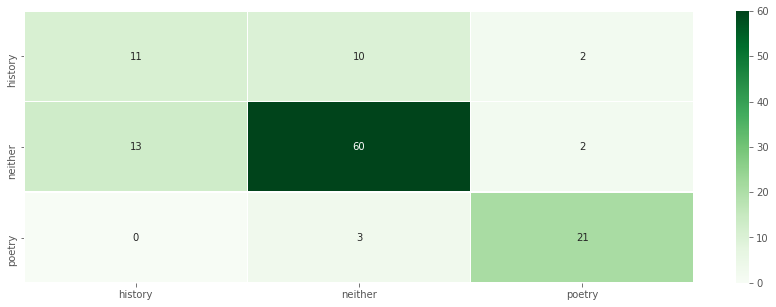

In [28]:
cm = confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm, columns=clf.classes_, index=clf.classes_)
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cm_df,annot=True,cmap='Greens',linewidths=.5)

In this confusion matrix, predicted values (the output of the model) are shown horizontally and expected values (what was in the original data) are shown vertically. When the two match, we can see the number of *true positives*, places where the predicted value matched the expected value. Those are the darker squares along the diagonal from top left to bottom right. Our model got history right 11 times, poetry right 21 times, and correctly predicted when a text was neither 60 times. 

The confusion matrix also shows false results---places where the predicted value did not match the expected value. Like we saw in the list above, the model miscategorized 3 texts originally labeled "neither" as poetry, for example. This could be a blind spot in our model, or it could be that we have more poetry texts in our data than we originally thought! We would have to examine the texts to find out.

What we can see from this matrix is that the model struggled the most with the history category. Look at the top row and the left-most column, where the history texts are categorized. Things are less neatly sorted into the top-left square of true positives as we'd like to see. Instead, history texts are sometimes misclassified as "neither," and "neither" texts are sometimes misclassified as history.

We can quantify what we're seeing in the confusion matrix with the final way of assessing our classifier: `sklearn`'s classification report. Here's the classification report that goes with the above matrix:

In [31]:
print(classification_report(y_test, y_pred, target_names=clf.classes_))

              precision    recall  f1-score   support

     history       0.46      0.48      0.47        23
     neither       0.82      0.80      0.81        75
      poetry       0.84      0.88      0.86        24

    accuracy                           0.75       122
   macro avg       0.71      0.72      0.71       122
weighted avg       0.76      0.75      0.76       122



The classification report gives us scores for the [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of the classifier across each category. Precision is the ratio of true positives (correct guesses of a text's category) to the number of total times it guessed that category. Recall is the ratio of true positives to the total number of texts in that category that existed in the dataset. So precision tells us how often the model guessed correctly while recall tells us how often the model found the right thing—two different views of a similar task. (If this is still confusing to you, I highly recommend the examples and visualizations in the [Wikipedia article on this topic](https://en.wikipedia.org/wiki/Precision_and_recall).)

The [F1-score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) combines these two measures, and "support" just shows the number of times that category appeared in our dataset (i.e. the total number of texts with that label).

How did our classifier do, according to this report? It did a decent job with the "neither" category, which makes sense since "neither" was the largest category. And it did really well with poetry! Especially with recall: if there was poetry in a text, our classifier could find it. Given that verse is distinctive compared to a nebulous genre like "history," it makes sense that this was the classifier's strength.

And we can can see that the history category is where the classifier really struggled. In fact, it's what's dragging down our overall accuracy score.  Both precision and recall are less than 50%: the classifier can neither find historical texts nor guess their label correctly. It's worse than a coin flip!

The classification report clarifies trends that were harder to see in our other methods of model assessment. Namely, one category (history) is badly suited to this method. Perhaps we could create a classifier that's quite good at identifying poetry texts, but we need to go back to the drawing board on history. This makes sense since, as I mentioned previously, "history" isn't a very well-defined genre in this corpus. Instead it's a subject label applied to lots of different kinds of texts. If we're really interested in correctly classifying historical texts, we may want to hand label a sample and start over with our model.

Just as we discovered with K-means clustering, it's easy to run these models but harder to assess and interpret their results. It requires a knowledge of the task at hand, a general idea of what's in the corpus, and a willingness to drill down to specific examples. The example we worked through above didn't work perfectly, and that makes it a good object lesson in supervised classification. You won't always find the right model or the right categories on the first try, and that's okay. By applying your knowledge of the corpus and some general principles of how classifiers work, you can still learn something from imperfect classifiers and work toward a model that does the job.